### Dataset

#### experimental structure
5 runs <br>
12 trials per run <br>
4 conditions 
- cond 1: low GO, low U
- cond 2: low GO, high U
- cond 3: high GO, low U
- cond 4: high GO, high U <br>

No_subs = 49

No_conditions = 6 <br>
6 types of events per trial <br>
list of conditions: 'caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit' <br>

#### possibilities of modelling data per sub
- __one beta map per run__
- one beta map per x trials, x={1,2,3,6}
- one beta map per condition --> we will model conditions rather than the events within a trial

#### tutorial link
https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

In [19]:
import nibabel as nib
import os
import numpy as np

In [20]:
# load beta images
# And clean them, replacing nans by 0s ...
from nilearn.image import clean_img
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)
#for i, map in enumerate(beta_maps):
#    data = map.get_fdata()
#    isnan = np.isnan(data)
#    print('Percentage of nan values for map {}: '.format(i), isnan[isnan==True].size / isnan.size)
## Standardize False because not the same statistic for all the subjects ( I think... )
print('Number of subjects: ', nb_sub)
#print('Number of beta maps: ', beta_maps_shape[-1])
#print('Shape of one beta map: ', beta_maps_shape[:-1]) # check: it should be (91, 109, 91, 30), meaning there are 30 3D images


Number of subjects:  49


Shape of the mask:  (241, 287, 242)
Shape of the downsampled mask:  (91, 109, 91)


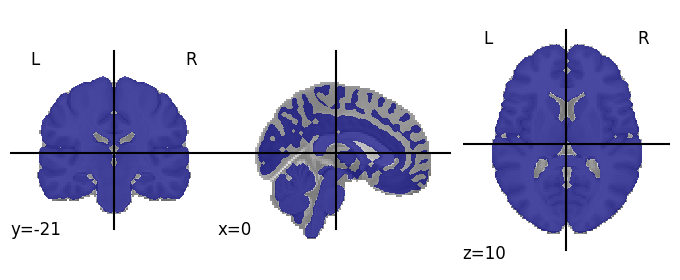

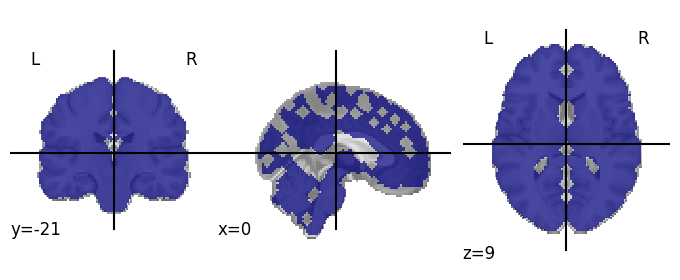

In [21]:
# create brain mask 
from nilearn.image import resample_to_img
from nilearn.masking import compute_brain_mask

anat_path = 'data/anatomy/average_T1_51subs_FE.nii'
anatomy = nib.load(anat_path)
mask_init_res = compute_brain_mask(anatomy)
anatomy = resample_to_img(anatomy, beta_maps[0])
mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask_init_res.shape)
from nilearn.plotting import plot_roi
plot_roi(mask_init_res)

print('Shape of the downsampled mask: ', mask.shape)
plot_roi(mask)

In [22]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask)
from tqdm import tqdm
samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

100%|██████████| 49/49 [00:29<00:00,  1.65it/s]


 Size of samples if we use the inital mask:  
 49 * 30 * 3403613   
 If we use the downsampled mask:  
 49 * 30 * 216734  
 Which is way better for computation time  

In [23]:
print(samples.shape)

(1470, 216734)


We have 49 subs, and for each of them there is 30 beta maps, which correspong to a training sample. Hence we need 30*49 labels

In [24]:
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*nb_sub)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


In [25]:
masked_epi = masker.inverse_transform(samples)
masked_epi.shape

(91, 109, 91, 1470)

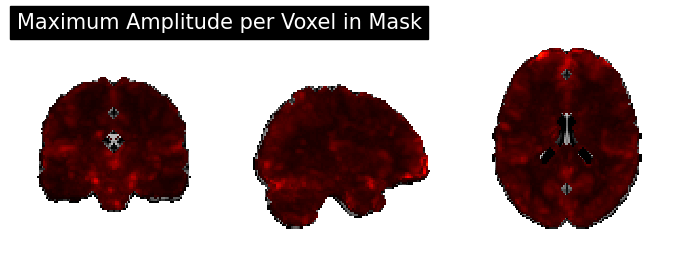

In [26]:
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map

max_zscores = math_img("np.abs(img).max(axis=3)", img=masked_epi)
plot_stat_map(max_zscores, dim=-.5, cut_coords=[33, -20, 20],
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

In [31]:
# Let's specify the classifier
from sklearn.svm import SVC
clf = SVC(gamma=2, C=1, verbose=True, max_iter=100)

In [32]:
clf.fit(samples, labels)

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho =

/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
Total nSV = 600


SVC(C=1, gamma=2, max_iter=100, verbose=True)

In [33]:
res = clf.predict(samples)

In [34]:
(res == labels).sum()

745

think about which kinds of classifiers would you like to use and why? <br>
which other models that are not in the tutorial would you think could be interesting to test out? <br>


### Cross validation
read the paper and emulate their CV paradigm. <br>

__potential possibilities__
- leave one run out, one model per sub
- leave one run out per sub
- leave one subject out 